## Imports


In [1]:
!pip install lightning matplotlib tensorboard einops > /dev/null 2>&1
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
import os
import numpy as np
from einops import rearrange
from utils import *

DATASET_PATH = "data"
CHECKPOINT_PATH = "checkpoints"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

torch.set_float32_matmul_precision("medium")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

Seed set to 42


Device: cuda


## Data


Files already downloaded and verified
Files already downloaded and verified


Seed set to 42
Seed set to 42


Files already downloaded and verified


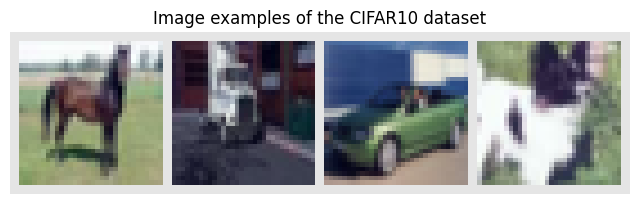

In [3]:
batch_size = 128
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
torch.random.manual_seed(42)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Transformer Definition


In [19]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = torch.nn.LayerNorm((embed_dim, 32, 32))
        self.q_net = torch.nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1)
        self.k_net = torch.nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1)
        self.v_net = torch.nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1)
        self.head_unification = torch.nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1)
        self.layer_norm_2 = torch.nn.LayerNorm((embed_dim, 32, 32))
        self.feed_forward = torch.nn.Sequential(
            torch.nn.Conv2d(embed_dim, hidden_dim, kernel_size=3, padding=1),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv2d(hidden_dim, embed_dim, kernel_size=3, padding=1),
            torch.nn.Dropout(dropout),
        )
        self.num_heads = num_heads

    # def spatial_linear_self_attention(self, Q, K, V):
    #     """
    #     Q: (B, D, H, W)
    #     K: (B, D, H, W)
    #     V: (B, D, H, W)
    #     """
    #     B, D, H, W = Q.shape
    #     Q = rearrange(Q, "b d h w -> b (h w) d")  # (B, HW, Dq)
    #     K = rearrange(K, "b d h w -> b (h w) d")  # (B, HW, Dq)
    #     V = rearrange(V, "b d h w -> b (h w) d")  # (B, HW, Dv)

    #     Q = torch.nn.functional.softmax(Q, dim=-2)  # (B, HW, Dq)
    #     K = torch.nn.functional.softmax(K, dim=-1)  # (B, HW, Dq)

    #     def break_into_heads(M):
    #         return rearrange(
    #             torch.cat(M.unsqueeze(0).chunk(self.num_heads, dim=-1), dim=0),
    #             "head b (h w) d -> (b head) (h w) d",
    #             h=H,
    #             w=W,
    #             b=B,
    #             head=self.num_heads,
    #             d=D // self.num_heads,
    #         )

    #     Q = break_into_heads(Q)  # (B * num_heads, HW, D//num_heads)
    #     K = break_into_heads(K)  # (B * num_heads, HW, D//num_heads)
    #     V = break_into_heads(V)  # (B * num_heads, HW, D//num_heads)

    #     # K (B * num_heads, H, W, Dq//num_heads)
    #     # V (B * num_heads, H, W, Dv//num_heads)
    #     # KV (B * num_heads, Dq//num_heads, Dv//num_heads)
    #     # This should inner product of each channel of K and V
    #     # KV[b, i, j] = sum(K[b, :, :, i] (H, W) * V[b, :, :, j] (H, W))

    #     KV = torch.bmm(K.permute(0, 2, 1), V)  # (B * num_heads, Dq//num_heads, Dv//num_heads)

    #     # Q (B * num_heads, H, W, Dq//num_heads)
    #     # KV (B * num_heads, Dq//num_heads, Dv//num_heads)
    #     # functional conv2d
    #     # weight: KV[i, :, :].unsqueeze(-1).unsqueeze(-1)
    #     # input: Q.permute(0, 3, 1, 2)

    #     QKV = torch.bmm(Q, KV)  # (B * num_heads, HW, Dv//num_heads)
    #     QKV = rearrange(
    #         QKV, "(b head) (h w) d -> b (head d) h w", h=H, w=W, b=B, head=self.num_heads, d=D // self.num_heads
    #     )  # (B, D, H, W)
    #     QKV = self.head_unification(QKV)
    #     return QKV

    def spatial_linear_self_attention(self, Q, K, V):
        """
        Q: (B, Dq, H, W)
        K: (B, Dq, H, W)
        V: (B, Dv, H, W)
        """

        B, Dq, H, W = Q.shape
        _, Dv, _, _ = V.shape
        h = self.num_heads

        assert_shape(Q, (B, Dq, H, W))
        assert_shape(K, (B, Dq, H, W))
        assert_shape(V, (B, Dv, H, W))

        Q = torch.nn.functional.softmax(Q, dim=-3)
        assert_shape(Q, (B, Dq, H, W))

        # Can we do this without flattening?
        K = torch.nn.functional.softmax(K.flatten(-2), dim=-1).reshape(B, Dq, H, W)
        assert_shape(K, (B, Dq, H, W))

        def break_into_heads(M):
            out = torch.cat(M.unsqueeze(0).permute(1, 0, 2, 3, 4).chunk(h, dim=-3), dim=1).flatten(0, 1)
            return out

        Q = break_into_heads(Q)
        assert_shape(Q, (B * h, Dq // h, H, W))

        K = break_into_heads(K)
        assert_shape(K, (B * h, Dq // h, H, W))

        V = break_into_heads(V)
        assert_shape(V, (B * h, Dv // h, H, W))

        # K (B * num_heads, H, W, Dq//num_heads)
        # V (B * num_heads, H, W, Dv//num_heads)
        # KV (B * num_heads, Dq//num_heads, Dv//num_heads)
        # This should inner product of each channel of K and V
        # KV[b, i, j] = sum(K[b, :, :, i] (H, W) * V[b, :, :, j] (H, W))

        KV = (K.unsqueeze(2) * V.unsqueeze(1)).sum(dim=[-1, -2])
        assert_shape(KV, (B * h, Dq // h, Dv // h))

        # Q (B * num_heads, H, W, Dq//num_heads)
        # KV (B * num_heads, Dq//num_heads, Dv//num_heads)
        # functional conv2d
        # weight: KV[i, :, :].unsqueeze(-1).unsqueeze(-1)
        # input: Q.permute(0, 3, 1, 2)

        kernels = KV.unsqueeze(-1).unsqueeze(-1)
        assert_shape(kernels, (B * h, Dq // h, Dv // h, 1, 1))

        input_tensor = Q
        assert_shape(input_tensor, (B * h, Dq // h, H, W))

        # QKV[B, D, H, W] = Q[B, D, H, W] * Kernels[B, D, D', 1, 1]

        QKV = torch.nn.functional.conv2d(input_tensor, kernels)

        QKV = self.head_unification(QKV)
        return QKV

    def forward(self, x):
        B, D, H, W = x.shape
        after_norm_1 = self.layer_norm_1(x)
        Q = self.q_net(after_norm_1)
        K = self.k_net(after_norm_1)
        V = self.v_net(after_norm_1)
        attn = self.spatial_linear_self_attention(Q, K, V)
        x = x + attn
        x = self.layer_norm_2(x)
        x = x + self.feed_forward(x)
        return x

In [ ]:
kernels = torch.randn(128, 256, 256, 1, 1)
input_tensor = torch.randn(128, 256, 32, 32)

QKV_all_loops

## Model Definition


In [20]:
class VisionTransformer(torch.nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        kernel_size = 3
        self.input_layer_cnn = torch.nn.Sequential(
            torch.nn.ZeroPad2d(same_padding(kernel_size)),
            torch.nn.Conv2d(num_channels, num_channels, kernel_size=kernel_size, stride=1, padding=0, groups=num_channels),
            torch.nn.Conv2d(num_channels, embed_dim, kernel_size=1, stride=1, padding=0),
            torch.nn.GELU(),
        )
        self.transformer = torch.nn.Sequential(
            *(TransformerBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.classification_head = torch.nn.Sequential(torch.nn.LayerNorm(embed_dim), torch.nn.Linear(embed_dim, num_classes))
        self.dropout = torch.nn.Dropout(dropout)

        self.positional_bias = torch.nn.Parameter(torch.randn(embed_dim, 32, 32))

    def forward(self, x):
        # Apply depthwise separable convolution embedding
        x = self.input_layer_cnn(x)  # (B, D, H, W)
        B, D, H, W = x.shape

        # Add positional embedding
        pos_embedding = self.positional_bias.unsqueeze(0).repeat(B, 1, 1, 1)  # (B, D, H, W)
        x = x + pos_embedding

        # Apply Transforrmer
        x = self.dropout(x)
        x = self.transformer(x)

        # Global Average Pooling
        pooled = x.reshape(B, D, -1).mean(dim=-1)  # (B, D, H, W) -> (B, D, HW) -> (B, D)

        # Classification
        out = self.classification_head(pooled)
        return out

## Model Wrapper


In [21]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = torch.nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")


def train_model(**kwargs):
    print("Initializing model and trainer...")
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        precision="16-mixed",
        devices=1,
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    print("Checking for pretrained model...")
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    # if os.path.isfile(pretrained_filename):
    if False:
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = ViT.load_from_checkpoint(pretrained_filename)
    else:
        print("No pretrained model found, training from scratch...")
        L.seed_everything(42)  # To be reproducible
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

## Training the Model


In [22]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "num_channels": 3,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)

print("ViT results", results)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42


Initializing model and trainer...
Checking for pretrained model...
No pretrained model found, training from scratch...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: batch1 must be a 3D tensor